# RNN 및 LSTM 예제

## 기본구조 예제

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# 1. 데이터 준비
# 간단한 시계열 데이터 생성 (y = x_t + x_{t-1})
def generate_data(seq_length, n_samples):
    X, y = [], []
    for _ in range(n_samples):
        seq = np.random.rand(seq_length)
        X.append(seq[:-1])  # 마지막 값을 제외한 입력 시퀀스
        y.append(seq[-1])   # 마지막 값이 타겟
    return np.array(X), np.array(y)

seq_length = 10
n_samples = 1000
X, y = generate_data(seq_length, n_samples)

In [3]:
# 데이터 차원 변환 (RNN/LSTM 입력 형식: (samples, timesteps, features))
X = X.reshape((X.shape[0], X.shape[1], 1))  # features = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# 2. 모델 정의
# RNN 모델
rnn_model = Sequential([
    SimpleRNN(10, activation='tanh', input_shape=(seq_length - 1, 1)),
    Dense(1)  # 출력값
])

/Users/jojungon/AI_Project/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# 2. 모델 정의
# RNN 모델
rnn_model = Sequential([
    SimpleRNN(10, activation='tanh', input_shape=(seq_length - 1, 1)),
    Dense(1)  # 출력값
])

In [6]:
# LSTM 모델
lstm_model = Sequential([
    LSTM(10, activation='tanh', input_shape=(seq_length - 1, 1)),
    Dense(1)  # 출력값
])

In [7]:
# 3. 모델 컴파일
for model in [rnn_model, lstm_model]:
    model.compile(optimizer='adam', loss='mse')

In [8]:
# 4. 모델 학습
print("Training RNN model...")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0) # verbose = 0 : epoch 과정 생략
print("Training LSTM model...")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

Training RNN model...
Training LSTM model...


In [9]:
# 5. 예측 및 평가
rnn_predictions = rnn_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [10]:
# 모델 성능 평가
rnn_mse = mean_squared_error(y_test, rnn_predictions)
lstm_mse = mean_squared_error(y_test, lstm_predictions)

In [11]:
print(f"RNN MSE: {rnn_mse:.4f}")
print(f"LSTM MSE: {lstm_mse:.4f}")

RNN MSE: 0.0795
LSTM MSE: 0.0839


## 예측값 생성 예제(LSTM 기반 전력량 예측)

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential # type: ignore
from keras.layers import LSTM, Dense, Dropout # type: ignore
import numpy as np
import os
from sqlalchemy import create_engine, text
import pymysql
import sqlalchemy

In [7]:
# 데이터 로드
df_concat = pd.read_csv("../dataset/watertot.csv", encoding="CP949")
df_concat.head()

,일자,총유입수량,전력량
0,2021-01-01,6134,15335.0
1,2021-01-02,6155,15387.5
2,2021-01-03,6024,15060.0
3,2021-01-04,6011,15027.5
4,2021-01-05,6025,15062.5


In [12]:
# 폰트 지정
plt.rcParams["font.family"] = "NanumGothic"

# 마이너스 부호 깨짐 지정
plt.rcParams["axes.unicode_minus"] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = "{:.2f}".format

In [13]:
df_concat["일자"] = pd.to_datetime(df_concat["일자"])
df_concat.shape

(1096, 3)

In [14]:
# 이상값 제거(표준편차 기반)
df_concat = df_concat[(df_concat["총유입수량"] - df_concat["총유입수량"].mean()).abs() < 3 * df_concat["총유입수량"].std()]
df_concat = df_concat[(df_concat["전력량"] - df_concat["전력량"].mean()).abs() < 3 * df_concat["전력량"].std()]

In [15]:
# 시계열 데이터를 고려하여 학습 및 테스트 데이터 분리
df_concat = df_concat.sort_values(by="일자")
train_size = 0.8
split_index = int(len(df_concat) * train_size)
train, test = df_concat[:split_index], df_concat[split_index:]

In [16]:
# 표준화
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[["총유입수량", "전력량"]])
test_scaled = scaler.transform(test[["총유입수량", "전력량"]])

In [63]:
# 시계열 데이터 생성을 위한 파라미터
seq_length = 7

In [64]:
# 데이터 전처리 및 시계열 데이터 생성
def create_sequenes(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1]) # 예측 대상이 아닌 feature들
        y.append(data[i+seq_length, -1]) # 마지막 열은 전력량
    return np.array(X), np.array(y).reshape(-1, 1)

In [67]:
# 시계열 데이터 생성
X_train, y_train = create_sequenes(train_scaled, seq_length)
X_test, y_test = create_sequenes(test_scaled, seq_length)
X_train.shape

(845, 7, 1)

In [68]:
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(64, activation="tanh", return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(Dropout(0.2)) # 과적합(overfitting) 방지를 위해 임의적으로 20% 뉴런을 무작위로 비활성화
model.add(LSTM(32, activation="tanh"))
model.add(Dropout(0.2))
model.add(Dense(1))

/Users/jojungon/AI_Project/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
# 모델 컴파일
model.compile(optimizer="adam", loss="mean_squared_error")

In [70]:
# 모델 학습 및 history에 저장
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/50
53/53 - 1s - 17ms/step - loss: 0.6010 - val_loss: 0.4517
Epoch 2/50
53/53 - 0s - 2ms/step - loss: 0.4723 - val_loss: 0.4433
Epoch 3/50
53/53 - 0s - 2ms/step - loss: 0.4500 - val_loss: 0.4345
Epoch 4/50
53/53 - 0s - 2ms/step - loss: 0.4397 - val_loss: 0.4350
Epoch 5/50
53/53 - 0s - 2ms/step - loss: 0.4324 - val_loss: 0.4310
Epoch 6/50
53/53 - 0s - 2ms/step - loss: 0.4197 - val_loss: 0.4215
Epoch 7/50
53/53 - 0s - 2ms/step - loss: 0.4037 - val_loss: 0.4039
Epoch 8/50
53/53 - 0s - 2ms/step - loss: 0.3992 - val_loss: 0.4064
Epoch 9/50
53/53 - 0s - 2ms/step - loss: 0.3959 - val_loss: 0.3972
Epoch 10/50
53/53 - 0s - 2ms/step - loss: 0.3869 - val_loss: 0.3799
Epoch 11/50
53/53 - 0s - 2ms/step - loss: 0.3862 - val_loss: 0.3728
Epoch 12/50
53/53 - 0s - 2ms/step - loss: 0.3756 - val_loss: 0.3724
Epoch 13/50
53/53 - 0s - 2ms/step - loss: 0.3780 - val_loss: 0.3721
Epoch 14/50
53/53 - 0s - 2ms/step - loss: 0.3717 - val_loss: 0.3624
Epoch 15/50
53/53 - 0s - 2ms/step - loss: 0.3704 - val_l

In [71]:
# 모델 저장
model.save("../model/lstm_model.keras")

In [72]:
# 예측값 계산
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [73]:
# 예측값 역변환
y_pred_inverse = scaler.inverse_transform(np.concatenate((test_scaled[seq_length:, :-1], y_pred), axis=1))[:, -1]

## 항공기 탑승객 수요 예측(LSTM)

In [22]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore

In [47]:
# 데이터 불러오기
data_path = "../dataset/airline.csv"
df = pd.read_csv(data_path)

# 데이터 확인
print(df.head())

         date  count
0  1949-01-01    112
1  1949-02-01    118
2  1949-03-01    132
3  1949-04-01    129
4  1949-05-01    121


In [48]:
# 날짜(Date)와 탑승객 수(count) 열의 이름 설정 및 변환
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

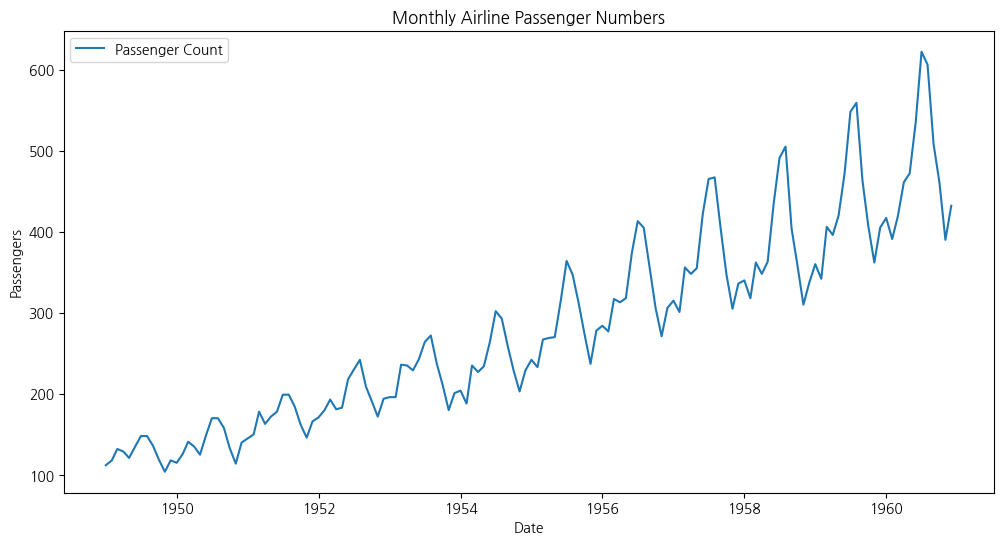

In [49]:
# 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(df["count"], label="Passenger Count")
plt.title("Monthly Airline Passenger Numbers")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

In [50]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[["count"]])

In [51]:
# 데이터셋 분리(학습 데이터와 테스트 데이터)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [52]:
# 시계열 데이터셋 생성 함수
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step])
    return np.array(X), np.array(y)

In [53]:
time_step = 12 # 12 개월 단위로 에측
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [54]:
# LSTM 입력에 맞게 데이터 형태 변경
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [55]:
# LSTM 모델 생성
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

/Users/jojungon/AI_Project/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
# 모델 컴파일
model.compile(optimizer="adam", loss="mean_squared_error")

In [57]:
# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2000, batch_size=32, verbose=1)

Epoch 1/2000


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0686 - val_loss: 0.0512
Epoch 2/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - val_loss: 0.0321
Epoch 3/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - val_loss: 0.0272
Epoch 4/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - val_loss: 0.0565
Epoch 5/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110 - val_loss: 0.0478
Epoch 6/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085 - val_loss: 0.0280
Epoch 7/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - val_loss: 0.0245
Epoch 8/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - val_loss: 0.0252
Epoch 9/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - val_loss: 0.0254
Epoch 10/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - val_loss: 0.0283
Epoch 11/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - val_loss: 0.0268
Epoch 12/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - val_loss: 0.02

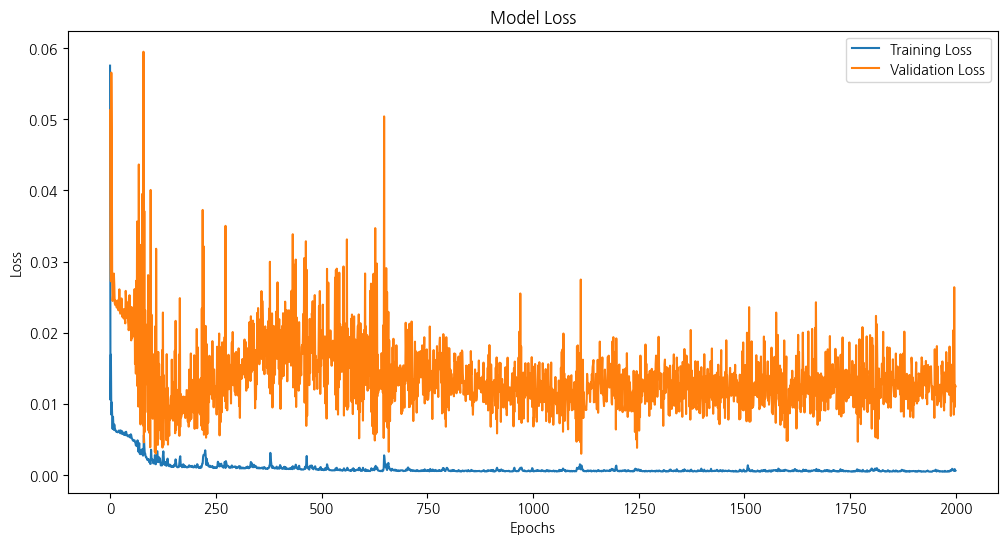

In [58]:
# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [59]:
# 테스트 데이터 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [60]:
# 예측값 역정규화
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

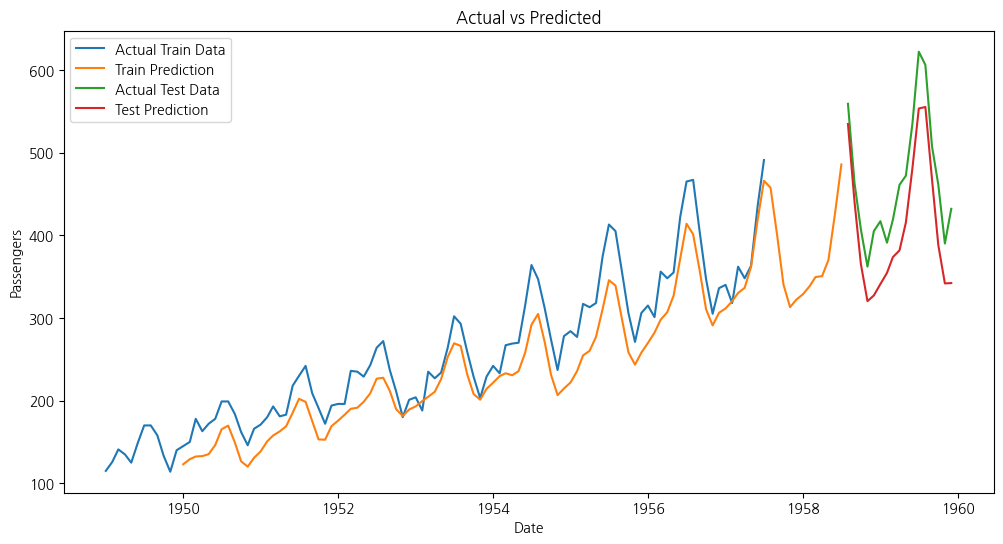

In [61]:
# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index[:len(y_train)], y_train, label='Actual Train Data')
plt.plot(df.index[time_step:len(train_predict) + time_step], train_predict, label='Train Prediction')
plt.plot(df.index[len(train_data):len(train_data) + len(test_predict)], y_test, label='Actual Test Data')
plt.plot(df.index[len(train_data):len(train_data) + len(test_predict)], test_predict, label='Test Prediction')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## 자전거 대여량 예측(GRU)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import GRU, Dense, Dropout # type: ignore
from sklearn.model_selection import train_test_split

In [88]:
# 1. 데이터 불러오기
dataset_path = '../dataset/'
train_data = pd.read_csv(dataset_path + 'train.csv')
test_data = pd.read_csv(dataset_path + 'test.csv')
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1


In [89]:
# 2. 데이터 전처리
def preprocess_data(data):
    data["datetime"] = pd.to_datetime(data["datetime"])
    data['hour'] = data['datetime'].dt.hour
    data['day'] = data['datetime'].dt.day
    data['month'] = data['datetime'].dt.month
    data['year'] = data['datetime'].dt.year

    data = data.drop(['datetime', 'casual', 'registered'], axis=1, errors='ignore')
    return data

In [90]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [92]:
# Feature와 Target분리
X = train_data.drop(["count"], axis=1).values
y = train_data["count"].values.reshape(-1, 1)

In [93]:
# MinMaxScaler를 사용하여 데이터 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [94]:
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

In [95]:
# Train/Test 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
# 데이터 차원 조정(GRU 입력 형태로 변환)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [97]:
# 4. GRU 모델 생성
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

/Users/jojungon/AI_Project/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [98]:
model.compile(optimizer="adam", loss="mse")
# 5. 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0326 - val_loss: 0.0293
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0295 - val_loss: 0.0268
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0283 - val_loss: 0.0252
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0256 - val_loss: 0.0233
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0245 - val_loss: 0.0211
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0223 - val_loss: 0.0190
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0204 - val_loss: 0.0165
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - val_loss: 0.0146
Epoch 9/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0147
Epoch 10/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0155 - val_loss: 0.0145
Epoch 11/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0150
Epoch 12/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

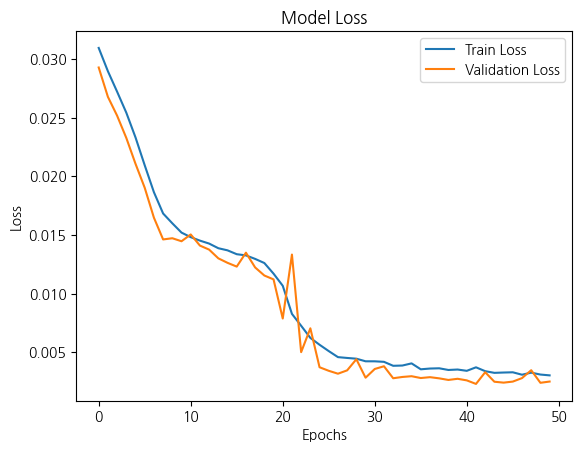

In [100]:
# 6. 학습 과정 시각화
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [101]:
# 7. 테스트 데이터 예측
X_test = scaler_X.transform(test_data.values)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [103]:
# 결과 저장
test_data["predicted_count"] = y_pred
test_data.to_csv(dataset_path + "test_predictions.csv", index=False)

## 꽃 이미지 분류 및 예측 예제(GRU)

In [28]:
# flower_photo 디렉토리 밑에 daisy, dandelion, roses, sunflowers, tulips 디렉토리 존재, 약 3670개 사진
import matplotlib.pyplot as plt
import numpy as np
import PIL # 여럭 각도에서 사이즈를 조절
import tensorflow as tf
from tensorflow.keras import layers # type: ignore
import os
import pathlib # 경로 url을 객체화 하여 속성 사용 가능
import urllib.request # url의 내용을 가져오는 기능
import tarfile # 서버의 데이터를 압축 및 압축 풀기 기능

In [5]:
# 데이터 다운로드 함수
def download_and_extract_data():
    # 데이터 URL
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    
    # 다운로드할 디렉토리 생성
    download_dir = os.path.join(os.getcwd(), "../dataset/flower_dataset")
    os.makedirs(download_dir, exist_ok=True)

    # 파일 다운로드
    tgz_path = os.path.join(download_dir, "flower_photos.tgz")

    if not os.path.exists(tgz_path):
        print("데이터셋 다운로드 중...")
        urllib.request.urlretrieve(dataset_url, tgz_path)
        print("다운로드 완료")

    # 압축 해제
    if not os.path.exists(os.path.join(download_dir, "flower_photos")):
        print("압축 해제 중...")
        with tarfile.open(tgz_path) as tar:
            tar.extractall(path=download_dir)
            print("압축 해제 완료!")

        return os.path.join(download_dir, "flower_photos")

In [6]:
# 데이터 다운로드 및 경로 설정
data_dir = download_and_extract_data()
data_dir = pathlib.Path(data_dir)

데이터셋 다운로드 중...
다운로드 완료
압축 해제 중...
압축 해제 완료!


In [7]:
# 클래스 및 이미지 개수 확인
classes = sorted([item.name for item in data_dir.glob("*/") if item.is_dir()]) # glob : 하위 디렉토리의 파일 갯수를 확인하기위한 method
image_count = len(list(data_dir.glob("*/*.jpg")))
print(f"발견된 클래스: {classes}")
print(f"총 이미지 개수: {image_count}")

발견된 클래스: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
총 이미지 개수: 3670


In [9]:
# 각 클래스별 이미지 개수 확인
for class_name in classes:
    class_images = len(list(data_dir.glob(f"{class_name}/*")))
    print(f"{class_name}: {class_images}개 이미지")

daisy: 633개 이미지
dandelion: 898개 이미지
roses: 641개 이미지
sunflowers: 699개 이미지
tulips: 799개 이미지


In [10]:
# 이미지 크기 및 배치 크기 설정
img_height = 180
img_width = 180
batch_size = 32

In [ ]:
# 훈련 데이터셋 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="training", # train data
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
# 검증 데이터셋 생성
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
# 클래스 이름 확인
class_names=train_ds.class_names
print("클래스:", class_names)
num_classes=len(class_names)

클래스: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [15]:
# 데이터셋 성능 최적화(이미지 파일 용량이 커 캐시에 저장해두고 필요할때 불러서 사용하는 방식)
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
# 데이터 증강 레이어 정의
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal"), # 학습을 위해 이미지를 회전(180도 회전)
    layers.RandomRotation(0.2), # 20도 회전
    layers.RandomZoom(0.2) # 20% 확대
])

2025-01-13 10:05:00.435838: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


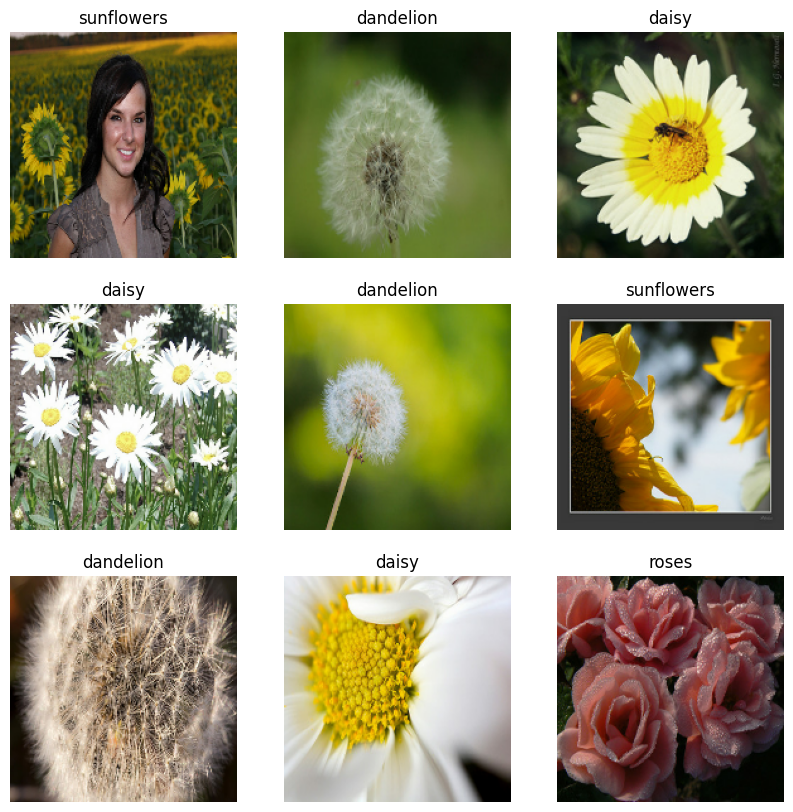

In [31]:
# 샘플 이미지 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [32]:
# CNN 모델 구성
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

/Users/jojungon/AI_Project/.venv/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
# 모델 컴파일
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # 다중 클래스 특화, 각 클래스별 확률 예측
    metrics=["accuracy"]
)

In [34]:
# 모델 구조 출력
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Earyl stopping 콜백 설정
callbacks =  [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

In [40]:
# 모델 학습
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.5283 - loss: 1.1083 - val_accuracy: 0.6008 - val_loss: 1.0003
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.5838 - loss: 1.0205 - val_accuracy: 0.6008 - val_loss: 0.9907
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.6489 - loss: 0.9129 - val_accuracy: 0.6444 - val_loss: 0.8997
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.6596 - loss: 0.8613 - val_accuracy: 0.6839 - val_loss: 0.8461
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.6832 - loss: 0.8166 - val_accuracy: 0.6635 - val_loss: 0.8584
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.6891 - loss: 0.8159 - val_accuracy: 0.6703 - val_loss: 0.9318
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.6976 - loss: 0.7977 - val_accuracy: 0.6689 - val_loss: 0.8122
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.7188 - loss: 0.7299 - val_accu

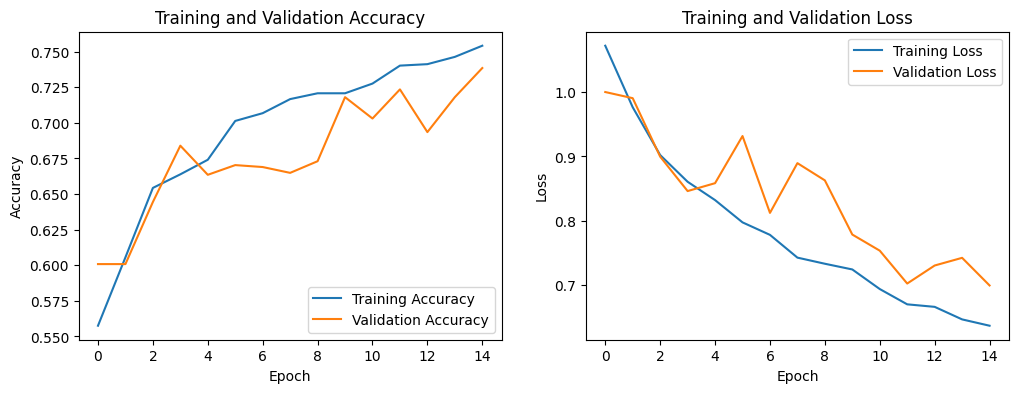

In [41]:

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [45]:
# 모델 저장
model.save('../model/flower_classification_model.h5')
print("모델이 'flower_classification_model.h5'로 저장되었습니다.")

모델이 'flower_classification_model.h5'로 저장되었습니다.


In [46]:
# 저장된 모델 불러오기
from tensorflow.keras.models import load_model # type: ignore

In [47]:
model_path = '../model/flower_classification_model.h5'  # 저장된 모델 경로
loaded_model = load_model(model_path)
print("저장된 모델이 성공적으로 로드되었습니다.")

저장된 모델이 성공적으로 로드되었습니다.


In [48]:
# 저장된 모델을 활용한 이미지 예측 함수
def predict_flower_with_loaded_model(img_path, model, class_names): 
    """
    이미지 경로와 모델을 입력받아 예측 결과를 출력하고 이미지를 시각화 하는 함수.
    
    Parameters:
        img_path(str): 예측할 이미지 파일 경로.
        model(tf.keras.Model): 저장된 모델.
        class_names(list): 클래스 이름 리스트.
    """

    # 이미지 로드 및 전처리
    img=tf.keras.preprocessing.image.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array, 0) # 배치 차원 추가

    # 예측 수행
    predictions=model.predict(img_array)
    score=tf.nn.softmax(predictions[0])

    # 예측 결과 출력
    print(
        "이 이미지는 '{}' ({:.2f}% 확률) 입니다."
        .format(class_names[np.argmax(score)], 100*np.max(score))
    )

    # 이미지 시각화
    plt.imshow(img)
    plt.axis("off")
    plt.show()


In [61]:
# 테스트 이미지 경로
# test_image_path = '../dataset/flower_dataset/flower_photos/daisy/5547758_eea9edfd54_n.jpg'
# test_image_path = '../dataset/flower_dataset/flower_photos/roses/12240303_80d87f77a3_n.jpg'
# test_image_path = '../dataset/flower_dataset/flower_photos/daisy/19865728236_a62f8f445b_n.jpg'
test_image_path = '../dataset/flower_dataset/flower_photos/tulips/17994129033_bbd0acba62_n.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
이 이미지는 'tulips' (36.46% 확률) 입니다.


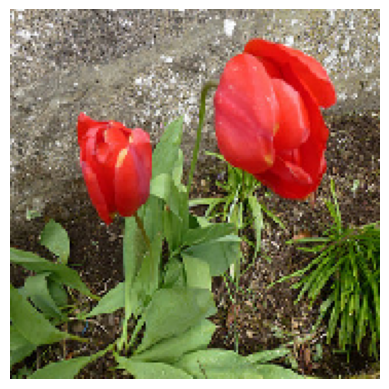

In [62]:
# 예측 실행
predict_flower_with_loaded_model(test_image_path, loaded_model, class_names)

## 클러스터링 예제(k-means)

In [63]:
import os
os.environ["OMP_NUM_THREADS"]="1"

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [66]:
dataset=pd.read_csv("../dataset/KMeansData.csv")
dataset[:5]

,hour,score
0,7.33,73
1,3.71,55
2,3.43,55
3,3.06,89
4,3.33,79


In [67]:
X=dataset.iloc[:,:].values
X[:5]

array([[ 7.33, 73.  ],
       [ 3.71, 55.  ],
       [ 3.43, 55.  ],
       [ 3.06, 89.  ],
       [ 3.33, 79.  ]])

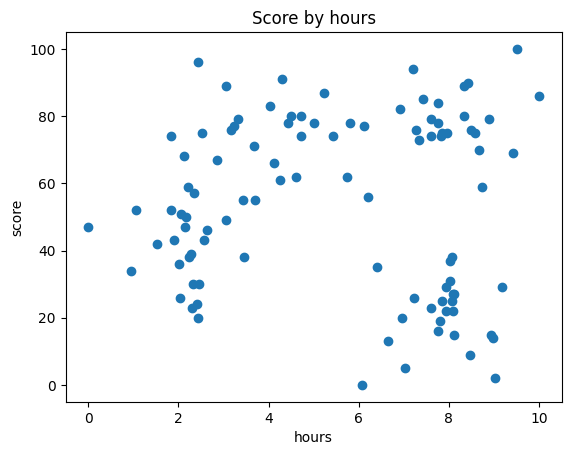

In [68]:
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

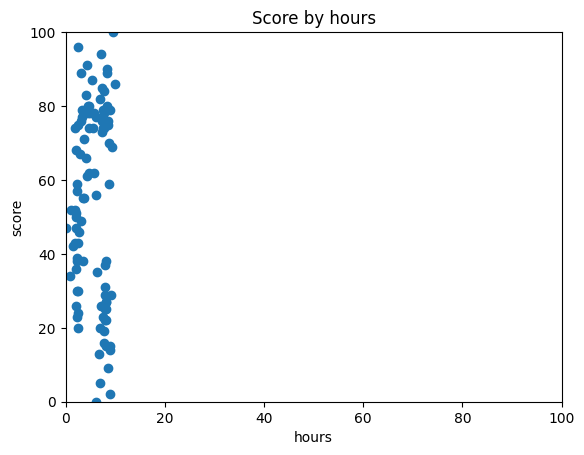

In [69]:
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.xlim(0, 100)
plt.ylabel('score')
plt.ylim(0, 100)
plt.show()

In [70]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X[:5]

array([[ 0.68729921,  0.73538376],
       [-0.66687438,  0.04198891],
       [-0.77161709,  0.04198891],
       [-0.9100271 ,  1.35173473],
       [-0.8090252 ,  0.96651537]])

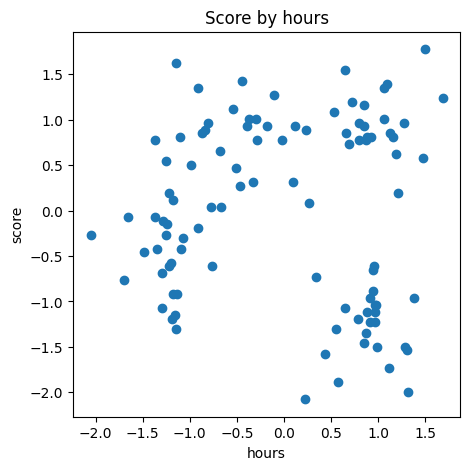

In [71]:
plt.figure(figsize =(5, 5))
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

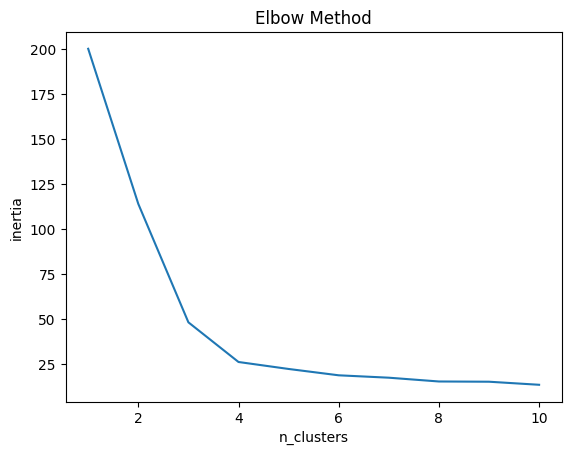

In [72]:
from sklearn.cluster import KMeans
inertia_list = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia_list)
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

In [73]:
K=4
kmeans = KMeans(n_clusters=K, random_state=0)
y_kmeans = kmeans.fit_predict(X)

In [74]:
y_kmeans

array([1, 0, 3, 0, 0, 2, 2, 0, 1, 0, 0, 3, 2, 3, 3, 0, 2, 1, 3, 0, 2, 0,
       3, 2, 1, 1, 3, 3, 3, 3, 2, 2, 3, 0, 1, 1, 3, 0, 0, 0, 3, 2, 1, 3,
       3, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 0, 0, 3, 2, 2, 1, 1, 1, 1, 2,
       2, 0, 2, 1, 3, 1, 1, 1, 3, 3, 3, 3, 0, 1, 2, 1, 2, 2, 1, 0, 3, 2,
       1, 3, 0, 2, 0, 1, 3, 0, 1, 0, 2, 3], dtype=int32)

In [75]:
centers = kmeans.cluster_centers_
centers

array([[-0.54299598,  0.79316666],
       [ 0.96910697,  0.97133061],
       [ 0.8837666 , -1.26929779],
       [-1.24939347, -0.48807293]])

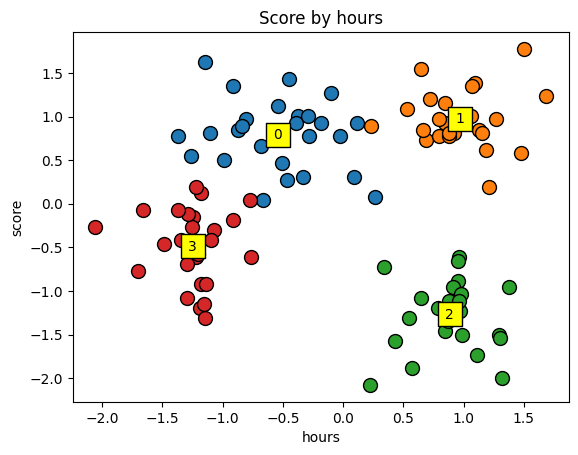

In [76]:
for cluster in range(K):
    plt.scatter(X[y_kmeans == cluster, 0], X[y_kmeans == cluster, 1], s=100, edgecolor='black')
    plt.scatter(centers[cluster, 0], centers[cluster, 1], s=300, edgecolor='black', color='yellow', marker='s')
    plt.text(centers[cluster, 0], centers[cluster, 1], cluster, va='center', ha='center')

plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

In [77]:
X_org = sc.inverse_transform(X)
X_org[:5]

array([[ 7.33, 73.  ],
       [ 3.71, 55.  ],
       [ 3.43, 55.  ],
       [ 3.06, 89.  ],
       [ 3.33, 79.  ]])

In [78]:
centers_org = sc.inverse_transform(centers)
centers_org

array([[ 4.04115385, 74.5       ],
       [ 8.08333333, 79.125     ],
       [ 7.8552    , 20.96      ],
       [ 2.1528    , 41.24      ]])

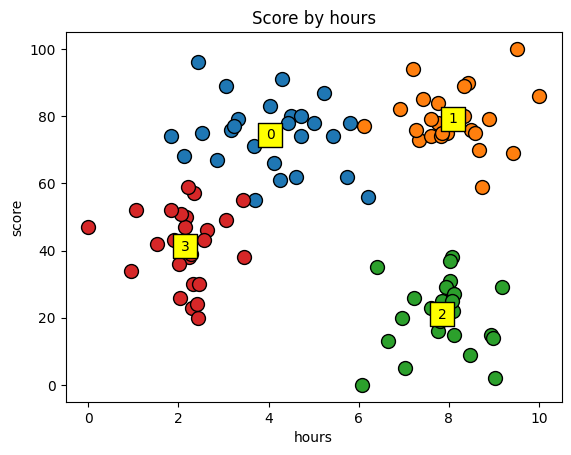

In [79]:
for cluster in range(K):
    plt.scatter(X_org[y_kmeans == cluster, 0], X_org[y_kmeans == cluster, 1], s=100, edgecolor='black')
    plt.scatter(centers_org[cluster, 0], centers_org[cluster, 1], s=300, edgecolor='black', color='yellow', marker='s')
    plt.text(centers_org[cluster, 0], centers_org[cluster, 1], cluster, va='center', ha='center')

plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()